<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2022/blob/main/notebooks/es12/AML_2022_QML_es12_simpleExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Machine Learning for Physics 2021-2022
## Hands-on session 12

Simple QML example

Pennylane library demo: https://pennylane.ai/qml/demos/tutorial_isingmodel_PyTorch.html

References:
* Maria Schuld and Francesco Petruccione. “Supervised Learning with Quantum Computers.” Springer, 2018.
* Andrew Lucas. “Ising formulations of many NP problems.” arXiv:1302.5843, 2014.
* Gary Kochenberger et al. “The Unconstrained Binary Quadratic Programming Problem: A Survey.” Journal of Combinatorial Optimization, 2014.

In [ ]:
# install pennylane libraries
!pip install pennylane --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 914 kB 25.2 MB/s 
     |████████████████████████████████| 1.6 MB 9.5 MB/s 
     |████████████████████████████████| 8.8 MB 51.6 MB/s 
     |████████████████████████████████| 108 kB 56.9 MB/s 


This basic tutorial optimizes a 3-qubit Ising model using the PennyLane default.qubit device with PyTorch. In the absence of external fields, the Hamiltonian for this system is given by: 

$H = - \sum_{<i,j>}J_{ij}\sigma_i\sigma_j$

where each spin can be in the +1 or -1 spin state and $J_{ij}$ are the nearest-neighbour coupling strengths.

For simplicity, the first spin can be assumed to be in the “up” state (+1 eigenstate of Pauli-Z operator) and the coupling matrix can be set to $J=[1,-1]$. The rotation angles for the other two spins are then optimized so that the energy of the system is minimized for the given couplings.

In [ ]:
import torch
from torch.autograd import Variable
import pennylane as qml
from pennylane import numpy as np

In [ ]:
# A three-qubit quantum circuit is initialized to represent the three spins:

dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev, interface="torch")
def circuit(p1, p2):
    # We use the general Rot(phi,theta,omega,wires) single-qubit operation
    qml.Rot(p1[0], p1[1], p1[2], wires=1)
    qml.Rot(p2[0], p2[1], p2[2], wires=2)
    return [qml.expval(qml.PauliZ(i)) for i in range(3)]


In [ ]:
# The cost function to be minimized is defined as the energy of the spin configuration:

def cost(var1, var2):
    # the circuit function returns a numpy array of Pauli-Z expectation values
    spins = circuit(var1, var2)

    # the expectation value of Pauli-Z is +1 for spin up and -1 for spin down
    energy = -(1 * spins[0] * spins[1]) - (-1 * spins[1] * spins[2])
    return energy

Let’s test the functions above using the $[s_1,s_2,s_3] = [1,-1,-1]$ spin configuration and the given coupling matrix. The total energy for this Ising model should be:

$H = -1(J_1s_1\otimes s_2 + J_2s_2\otimes s_3)=2$


In [ ]:
test1 = torch.tensor([0, np.pi, 0])
test2 = torch.tensor([0, np.pi, 0])

cost_check = cost(test1, test2)
print("Energy for [1, -1, -1] spin configuration:", cost_check.item())

Energy for [1, -1, -1] spin configuration: 2.0000000000000036


In [ ]:
# random initialization

torch.manual_seed(56)
p1 = Variable((np.pi * torch.rand(3, dtype=torch.float64)), requires_grad=True)
p2 = Variable((np.pi * torch.rand(3, dtype=torch.float64)), requires_grad=True)

var_init = [p1, p2]
cost_init = cost(p1, p2)

print("Randomly initialized angles:")
print(p1)
print(p2)
print("Corresponding cost before optimization:")
print(cost_init.item())

Randomly initialized angles:
tensor([1.9632, 2.6022, 2.3277], dtype=torch.float64, requires_grad=True)
tensor([0.6521, 2.8474, 2.4300], dtype=torch.float64, requires_grad=True)
Corresponding cost before optimization:
1.679212961854227


In [ ]:
# optimization: e.g.  use the PyTorch gradient descent optimizer to minimize the cost

opt = torch.optim.SGD(var_init, lr=0.1)

def closure(): #function (closure) that reevaluates the model and returns the loss
    opt.zero_grad() #sets all the gradients back to zero
    loss = cost(p1, p2)
    loss.backward() #computes the gradient of the cost function with respect to all parameters with requires_grad=True.
    return loss

var_pt = [var_init]
cost_pt = [cost_init]
x = [0]

for i in range(100):
    opt.step(closure) #performs the parameter update based on this current gradient and the learning rate.
    if (i + 1) % 5 == 0:
        x.append(i)
        p1n, p2n = opt.param_groups[0]["params"]
        costn = cost(p1n, p2n)
        var_pt.append([p1n, p2n])
        cost_pt.append(costn)

        # for clarity, the angles are printed as numpy arrays
        print("Energy after step {:5d}: {: .7f} | Angles: {}".format(
            i+1, costn, [p1n.detach().numpy(), p2n.detach().numpy()]),"\n"
        )



Energy after step     5:  0.6846474 | Angles: [array([1.96323939, 1.93604492, 2.32767565]), array([0.65212549, 2.73080219, 2.4299563 ])] 

Energy after step    10: -1.0138530 | Angles: [array([1.96323939, 1.0136468 , 2.32767565]), array([0.65212549, 2.73225282, 2.4299563 ])] 

Energy after step    15: -1.8171995 | Angles: [array([1.96323939, 0.38483073, 2.32767565]), array([0.65212549, 2.85992571, 2.4299563 ])] 

Energy after step    20: -1.9686584 | Angles: [array([1.96323939, 0.13026452, 2.32767565]), array([0.65212549, 2.97097572, 2.4299563 ])] 

Energy after step    25: -1.9930403 | Angles: [array([1.96323939, 0.04302756, 2.32767565]), array([0.65212549, 3.04042222, 2.4299563 ])] 

Energy after step    30: -1.9980133 | Angles: [array([1.96323939, 0.01413292, 2.32767565]), array([0.65212549, 3.08179844, 2.4299563 ])] 

Energy after step    35: -1.9993550 | Angles: [array([1.96323939, 0.00463472, 2.32767565]), array([0.65212549, 3.10627578, 2.4299563 ])] 

Energy after step    40: -1

as expected the minimum energy is -2 for the spin configuration $[s_1,s_2,s_3] = [1,1,-1]$ which corresponds to $(\phi,\theta,\omega)=(0,0,0)$ for the second spin and $(\phi,\theta,\omega)=(0,\pi,0)$ for the third spin. 

Note that gradient descent optimization might not find this global minimum due to the non-convex cost function, as is shown in the next section...

In [ ]:
p1_final, p2_final = opt.param_groups[0]["params"]
print("Optimized angles:")
print(p1_final)
print(p2_final)
print("Final cost after optimization:")
print(cost(p1_final, p2_final))

Optimized angles:
tensor([1.9632e+00, 2.3284e-09, 2.3277e+00], dtype=torch.float64,
       requires_grad=True)
tensor([0.6521, 3.1416, 2.4300], dtype=torch.float64, requires_grad=True)
Final cost after optimization:
tensor(-2.0000, dtype=torch.float64, grad_fn=<SubBackward0>)


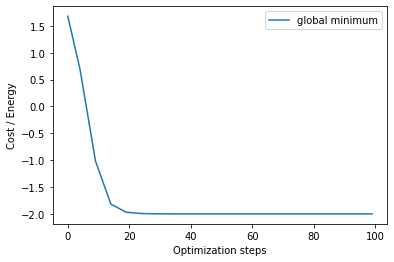

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4))

# Enable processing the Torch trainable tensors
with torch.no_grad():
    plt.plot(x, cost_pt, label = 'global minimum')
    plt.xlabel("Optimization steps")
    plt.ylabel("Cost / Energy")
    plt.legend()
    plt.show()

In [ ]:
#If the spins are initialized close to the local minimum of zero energy, 
#the optimizer is likely to get stuck here and never find the global minimum at -2.

torch.manual_seed(9)
p3 = Variable((np.pi*torch.rand(3, dtype = torch.float64)), requires_grad = True)
p4 = Variable((np.pi*torch.rand(3, dtype = torch.float64)), requires_grad = True)

var_init_loc = [p3, p4]
cost_init_loc = cost(p3, p4)

print("Corresponding cost before optimization:")
print(cost_init_loc)

Corresponding cost before optimization:
tensor(0.0082, dtype=torch.float64, grad_fn=<SubBackward0>)


In [ ]:
opt = torch.optim.SGD(var_init_loc, lr = 0.1)

def closure():
    opt.zero_grad()
    loss = cost(p3, p4)
    loss.backward()
    return loss

var_pt_loc = [var_init_loc]
cost_pt_loc = [cost_init_loc]

for j in range(100):
    opt.step(closure)
    if (j + 1) % 5 == 0:
        p3n, p4n = opt.param_groups[0]['params']
        costn = cost(p3n, p4n)
        var_pt_loc.append([p3n, p4n])
        cost_pt_loc.append(costn)

        # for clarity, the angles are printed as numpy arrays
        print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(
            j+1, costn, [p3n.detach().numpy(), p4n.detach().numpy()]),"\n"
        )


Energy after step     5:  0.0032761 | Angles: [array([0.77369911, 2.63471297, 1.07981163]), array([0.26038622, 0.08659858, 1.91060734])] 

Energy after step    10:  0.0013137 | Angles: [array([0.77369911, 2.63406019, 1.07981163]), array([0.26038622, 0.05483683, 1.91060734])] 

Energy after step    15:  0.0005266 | Angles: [array([0.77369911, 2.63379816, 1.07981163]), array([0.26038622, 0.03471974, 1.91060734])] 

Energy after step    20:  0.0002111 | Angles: [array([0.77369911, 2.63369307, 1.07981163]), array([0.26038622, 0.02198151, 1.91060734])] 

Energy after step    25:  0.0000846 | Angles: [array([0.77369911, 2.63365094, 1.07981163]), array([0.26038622, 0.01391648, 1.91060734])] 

Energy after step    30:  0.0000339 | Angles: [array([0.77369911, 2.63363405, 1.07981163]), array([0.26038622, 0.00881044, 1.91060734])] 

Energy after step    35:  0.0000136 | Angles: [array([0.77369911, 2.63362729, 1.07981163]), array([0.26038622, 0.00557782, 1.91060734])] 

Energy after step    40:  0

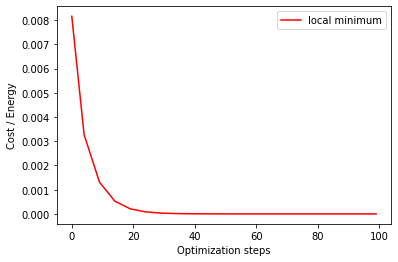

In [ ]:
fig = plt.figure(figsize=(6, 4))

# Enable processing the Torch trainable tensors
with torch.no_grad():
    plt.plot(x, cost_pt_loc, 'r', label = 'local minimum')
    plt.xlabel("Optimization steps")
    plt.ylabel("Cost / Energy")
    plt.legend()
    plt.show()